# Task 2
This serves as a template which will guide you through the implementation of this task. It is advised to first read the whole template and get a sense of the overall structure of the code before trying to fill in any of the TODO gaps.
This is the jupyter notebook version of the template. For the python file version, please refer to the file `template_solution.py`.

First, we import necessary libraries:

In [85]:
# data handling
import numpy as np
import pandas as pd
from scipy import stats
# Add any other imports you need here

# plotting
import seaborn as sns
from matplotlib import pyplot as plt

# preprocessing
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, Normalizer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_selector, make_column_transformer
from sklearn.cluster import KMeans

# training
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import rbf_kernel
# from sklearn.linear_model import LinearRegression
# from sklearn.tree import DecisionTreeRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, RBF, Matern, RationalQuadratic
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import randint, uniform


# set exploration options for print
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns

# set display to be interactive for pipelines
import sklearn
sklearn.set_config(display="diagram")

# Data Loading
TODO: Perform data preprocessing, imputation and extract X_test, y_train and X_test
(and potentially change initialization of variables to accomodate how you deal with non-numeric data)

In [2]:
"""
This loads the testing and test data, preprocesses it, removes the NaN
values and interpolates the missing data using imputation

Parameters
----------
Compute
----------
X_test: matrix of floats, testing input with features
y_train: array of floats, training output with labels
X_test: matrix of floats: dim = (100, ?), test input with features
"""
# Load training data
train_df = pd.read_csv("train.csv")
    
print("testing data:")
print("Shape:", train_df.shape)
print(train_df.head(2))
print('\n')
    
# Load test data
test_df = pd.read_csv("test.csv")

print("Test data:")
print(test_df.shape)
print(test_df.head(2))

testing data:
Shape: (900, 11)
   season  price_AUS  price_CHF  price_CZE  price_GER  price_ESP  price_FRA  \
0  spring        NaN   9.644028  -1.686248  -1.748076  -3.666005        NaN   
1  summer        NaN   7.246061  -2.132377  -2.054363  -3.295697  -4.104759   

   price_UK  price_ITA  price_POL  price_SVK  
0 -1.822720  -3.931031        NaN  -3.238197  
1 -1.826021        NaN        NaN  -3.212894  


Test data:
(100, 10)
   season  price_AUS  price_CZE  price_GER  price_ESP  price_FRA  price_UK  \
0  spring        NaN   0.472985   0.707957        NaN  -1.136441 -0.596703   
1  summer  -1.184837   0.358019        NaN  -3.199028  -1.069695       NaN   

   price_ITA  price_POL  price_SVK  
0        NaN   3.298693   1.921886  
1  -1.420091   3.238307        NaN  


## Preprocessing: NA handling in ground truth

In [3]:
## For now: drop NAs in ground truth
def groud_truth_NA_handling(full_df, y_col = "price_CHF"):
    yNA_mask = full_df[y_col].isna()
    X = full_df[~yNA_mask].drop([y_col],axis=1)
    y = full_df[~yNA_mask].loc[:,y_col]
    return X, y

X_train, y_train = groud_truth_NA_handling(train_df)
X_test = test_df.copy()

# given assert from task
assert (X_train.shape[1] == X_test.shape[1]) and (X_train.shape[0] == y_train.shape[0]) and (X_test.shape[0] == 100), "Invalid data shape"

## Preprocessing exploration: Encoding, Imputing and Scaling
Try out preprocessing in manual style, goal is normal distribution of features

In [4]:
## Encode the character values and impute the numerical ones
X_train_num = X_train.select_dtypes(include=['number'])
X_train_cat = X_train.select_dtypes(include=['object', 'category'])

# Encode the season column
one_hot_encoder = OneHotEncoder()
X_train_cat_encoder = one_hot_encoder.fit(X_train_cat)
X_train_cat_encoded = pd.DataFrame(X_train_cat_encoder.transform(X_train_cat).toarray(), 
                                    columns=X_train_cat_encoder.get_feature_names_out(), 
                                    index=X_train_cat.index)

In [5]:
# check function
def quick_check(data):
    data_num = data.select_dtypes(include = ["number"]).copy()
    data_cat = data.select_dtypes(include = ["object", "category"]).copy()
    # numerics
    check1 = data_num.describe().T
    check2 = pd.DataFrame(data_num.isna().sum(), columns = ["NA.counts"])
    num_check = pd.concat([check1, check2], axis = 1)

    # return num if there are no cat columns
    if data_cat.shape[1] == 0: 
        return num_check
    
    else:
        # cathegories
        check3 = pd.DataFrame(data_cat.value_counts(), columns = ["Counts"])
        check4 = pd.DataFrame(pd.get_dummies(data_cat).isna().sum(axis = 0), columns=["NA.counts"])
        cat_check = pd.concat([check3, check4], axis = 1)
        return num_check, cat_check

In [7]:
# Impute the features with KNNImputer or SimpleImputer
NN_explore = 5
imputer = KNNImputer(n_neighbors=NN_explore)

X_train_num_knnimputed = pd.DataFrame(imputer.fit_transform(X_train_num), 
                                   columns = X_train_num.columns, 
                                   index = X_train_num.index)

# Impute the features with the IterativeImputer
imputer = IterativeImputer()
X_train_num_iterimputed = pd.DataFrame(imputer.fit_transform(X_train_num), 
                                       columns = X_train_num.columns, 
                                       index = X_train_num.index)



X_train_preprocessed = pd.concat([X_train_num_iterimputed, X_train_cat_encoded], axis = 1)



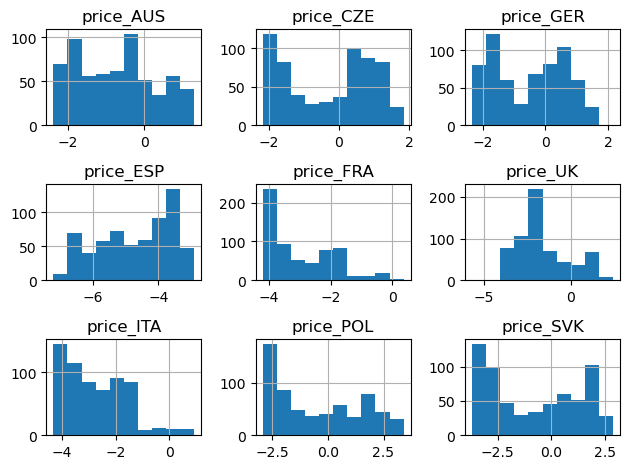

In [11]:
# we need to transform all feature distributions to a normal one
X_train_preprocessed.iloc[: ,:-4].hist()
plt.tight_layout()

### price_AUS -> bimodal distribution
* one solution would be to bin the data 
* another to use a similarity measure
* or finding a possible cause for the bimodality and split the data accordingly 

(array([  5.,   7.,  19.,  43.,  67.,  61.,  61.,  58.,  60., 250.]),
 array([-0.38449863, -0.34604877, -0.30759891, -0.26914904, -0.23069918,
        -0.19224932, -0.15379945, -0.11534959, -0.07689973, -0.03844986,
         0.        ]),
 <BarContainer object of 10 artists>)

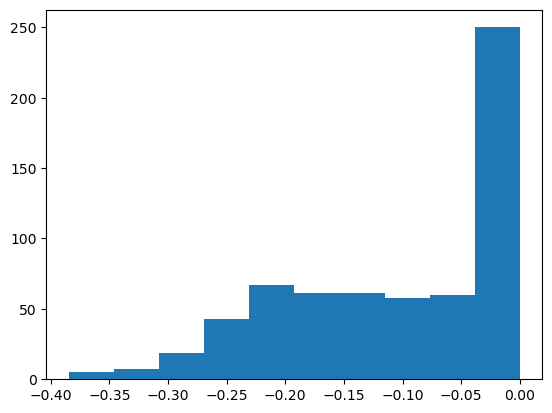

In [44]:

# similarity
AUS_median = X_train_preprocessed[["price_AUS"]].median().values
X_train_price_AUS = X_train_preprocessed[["price_AUS"]].values.reshape(-1, 1)
AUS_median = np.array([AUS_median]).reshape(1, -1)
# now we transform the modes with their similarity to the median
AUS_similarity_median = rbf_kernel(X_train_price_AUS, AUS_median, gamma=0.1)
# check the distribtution again
plt.hist(np.log(AUS_similarity_median.reshape(-1)))
# this is non sense



<Axes: >

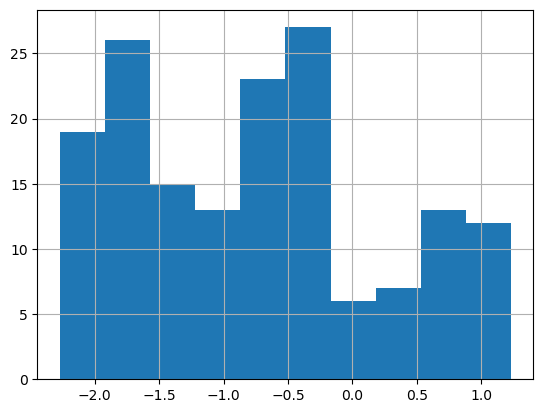

In [82]:
# let's try finding the cause for the bimodality, possibly the season
X_train_num_season = pd.concat([X_train_num_iterimputed,X_train_cat ], axis = 1)
season_mask = X_train_num_season["season"].isin(["autumn"])
X_train_num_season[season_mask].loc[:, "price_AUS"].hist()



c:\Users\paesc\anaconda3\envs\py311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\paesc\anaconda3\envs\py311\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


<Axes: xlabel='Count', ylabel='value'>

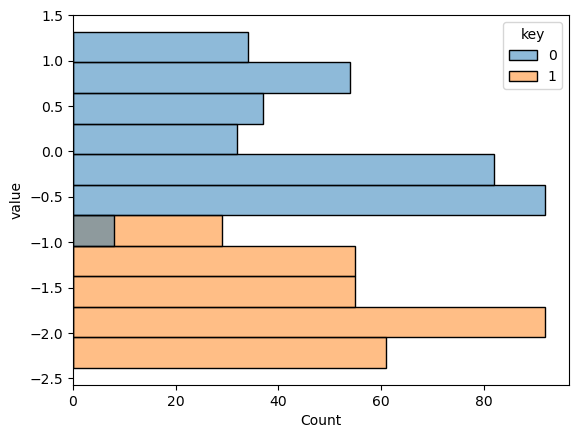

In [109]:
tbf = X_train_num_season.loc[:, "price_AUS"].to_numpy().reshape(-1, 1)
kmeans = KMeans(n_clusters=2).fit(tbf)
plot_AUS = pd.DataFrame({"value": tbf.reshape(-1), 
                         "key": kmeans.labels_})
sns.histplot(data = plot_AUS, y = "value", hue = "key")

In [45]:
print(X_train_price_AUS)

[[-1.69475320e+00]
 [-2.15108990e+00]
 [-2.10193661e+00]
 [-2.09847479e+00]
 [-1.96968697e+00]
 [-1.93520943e+00]
 [-1.45723153e+00]
 [-1.11125509e+00]
 [-1.04468796e+00]
 [ 5.06527547e-01]
 [ 9.46137753e-01]
 [ 1.03177892e+00]
 [ 9.68455144e-01]
 [ 9.61728641e-01]
 [ 1.10092740e+00]
 [ 1.01085966e+00]
 [ 4.08278611e-01]
 [ 4.86775630e-01]
 [ 2.19139181e-01]
 [ 1.09598365e-01]
 [ 3.73233861e-02]
 [ 7.56688036e-02]
 [-5.11127071e-02]
 [-1.51213751e-01]
 [ 1.62545593e-01]
 [-1.01093687e-02]
 [-2.46399197e-01]
 [-3.34459746e-02]
 [ 1.50771671e-01]
 [ 1.37084075e-01]
 [ 4.17567988e-01]
 [ 4.57522455e-01]
 [ 6.17021418e-01]
 [ 9.13503673e-01]
 [ 9.69077899e-01]
 [ 1.17421130e+00]
 [ 1.08554428e+00]
 [ 7.51013075e-01]
 [ 7.20794949e-01]
 [ 4.30193022e-01]
 [ 4.02169847e-01]
 [ 6.02910132e-02]
 [-5.61752563e-01]
 [-7.76300964e-01]
 [-1.08379061e+00]
 [-1.59543410e+00]
 [-1.65329266e+00]
 [-1.72697514e+00]
 [-1.76237736e+00]
 [-1.93161533e+00]
 [-1.86148779e+00]
 [-2.05114104e+00]
 [-2.3627833

In [ ]:
# Scale the numeric features
std_scaler = StandardScaler()
X_train_num_imputed_stdscaled = pd.DataFrame(std_scaler.fit_transform(X_train_num_iterimputed), 
                                   columns = X_train_num.columns, 
                                   index = X_train_num.index)

minmax_scaler = MinMaxScaler(feature_range=(-1, 1))
X_train_num_imputed_minmaxscaled = pd.DataFrame(minmax_scaler.fit_transform(X_train_num_iterimputed), 
                                   columns = X_train_num.columns, 
                                   index = X_train_num.index)

rob_scaler = RobustScaler()
X_train_num_imputed_robscaled = pd.DataFrame(rob_scaler.fit_transform(X_train_num_iterimputed), 
                                   columns = X_train_num.columns, 
                                   index = X_train_num.index)

norm_scaler = Normalizer()
X_train_num_imputed_normscaled = pd.DataFrame(norm_scaler.fit_transform(X_train_num_iterimputed), 
                                   columns = X_train_num.columns, 
                                   index = X_train_num.index)


We need to engineer every feature seperately

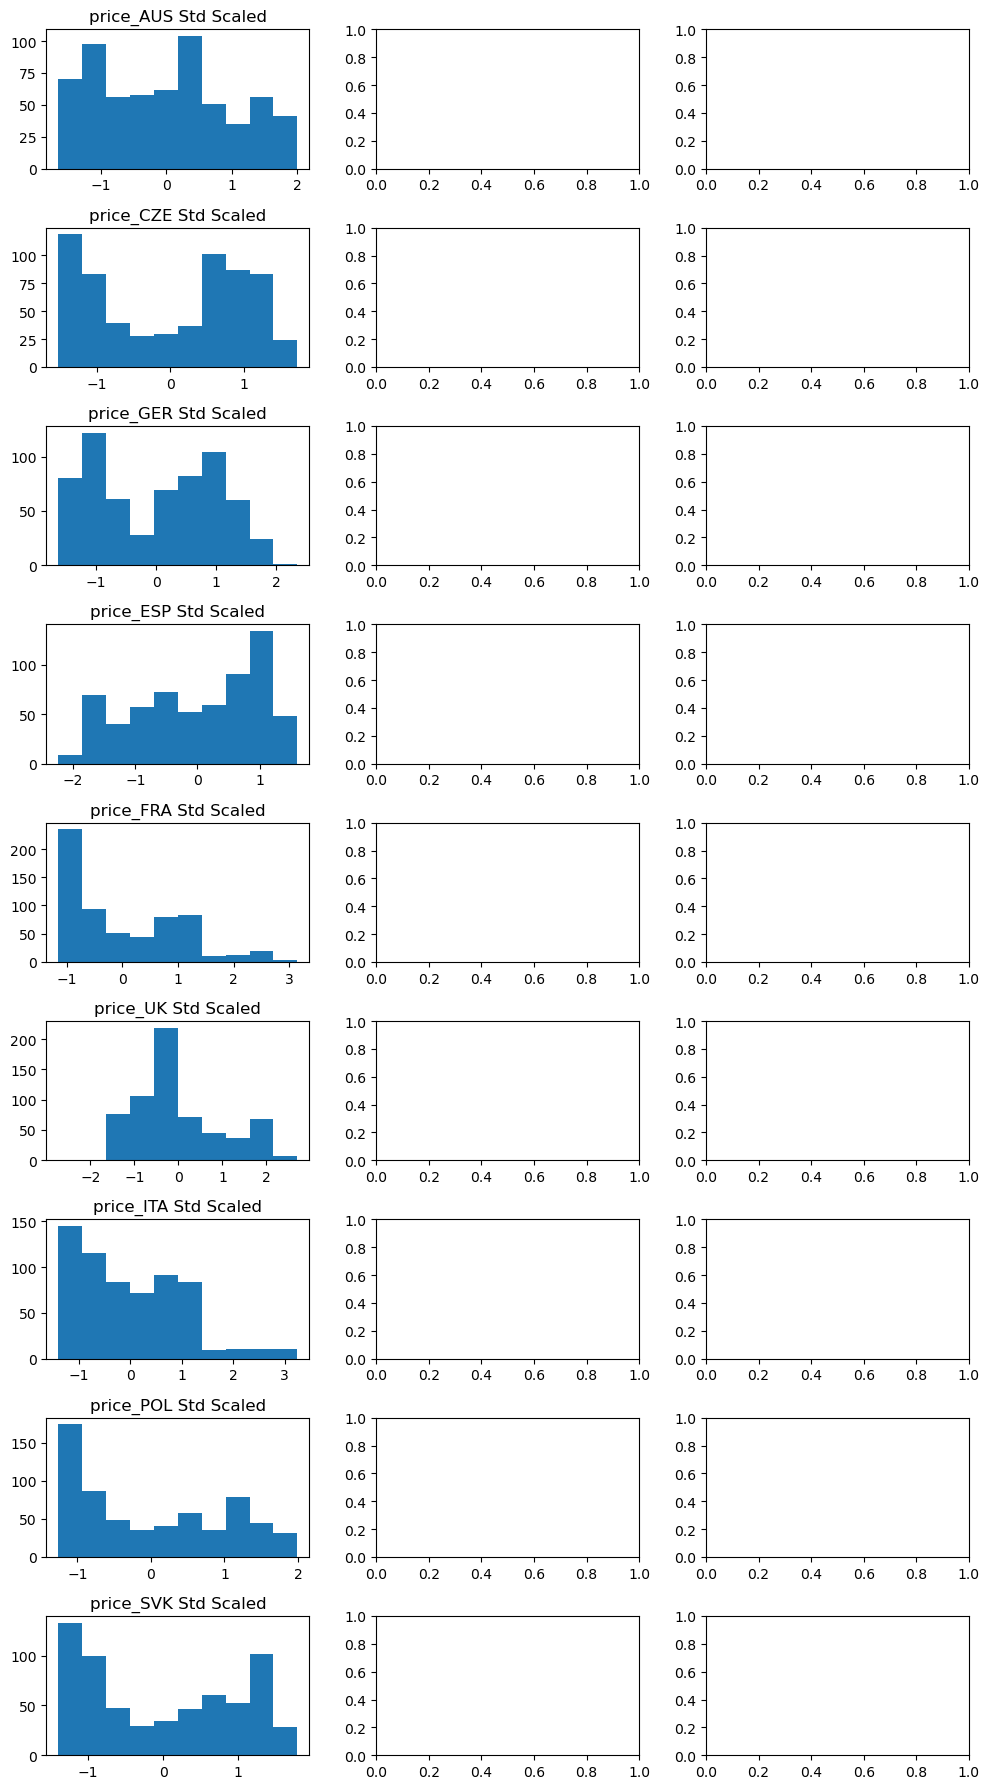

In [33]:
# check some distributions
# We need to engineer every feature seperately
fig, axs = plt.subplots(9, 4, figsize = (10, 18))
# axs = axs.ravel()
for i, feature in enumerate(X_train.columns[1:]):
    axs[i, 0].hist(X_train_num_imputed_stdscaled.loc[:, feature])
    axs[i, 0].set_title(f"{feature} Std Scaled")

plt.tight_layout()

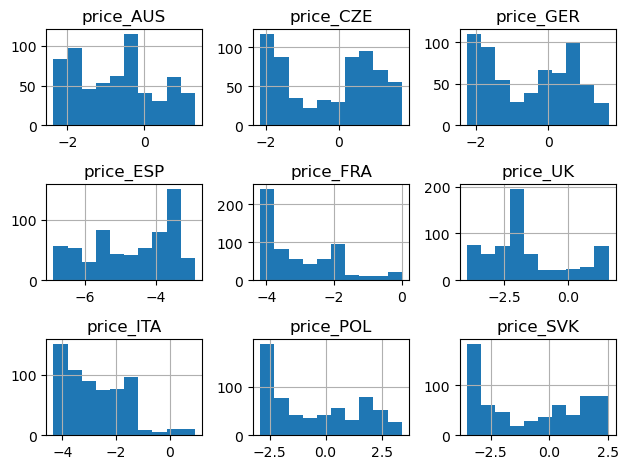

In [8]:
X_train_num_knnimputed.hist()
plt.tight_layout()

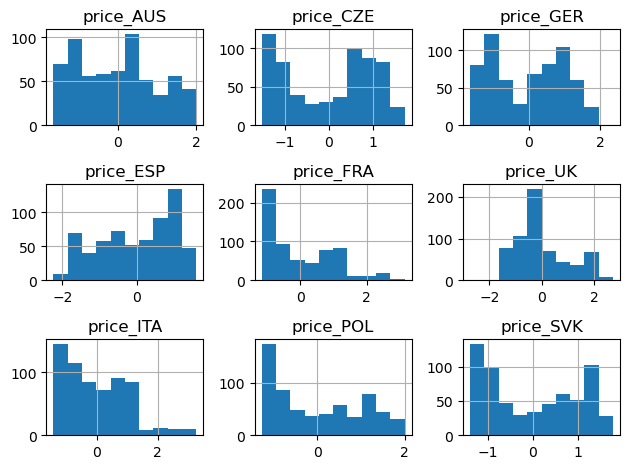

In [15]:
X_train_num_imputed_stdscaled.hist()
plt.tight_layout()

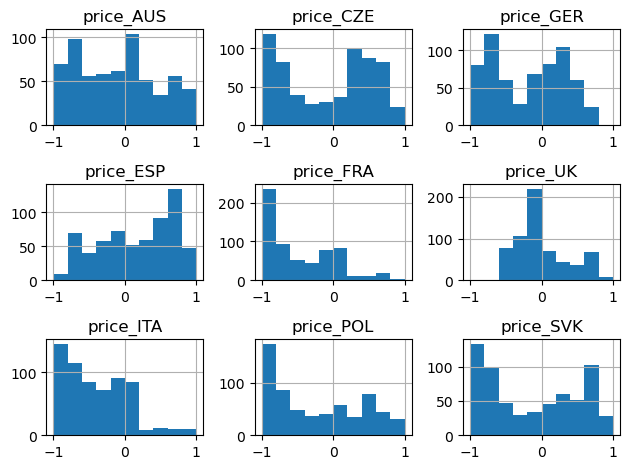

In [18]:
X_train_num_imputed_minmaxscaled.hist()
plt.tight_layout()

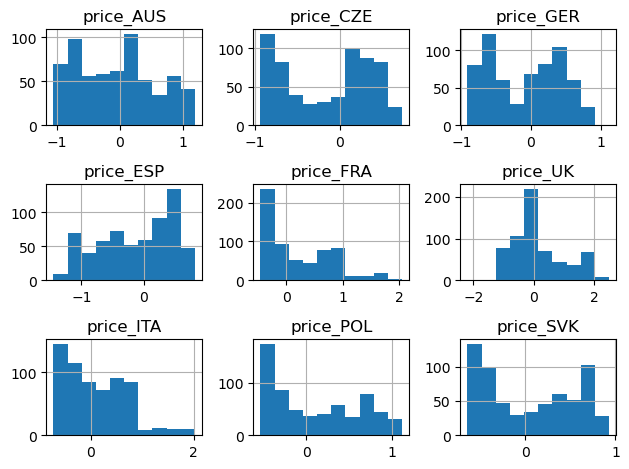

In [19]:
X_train_num_imputed_robscaled.hist()
plt.tight_layout()

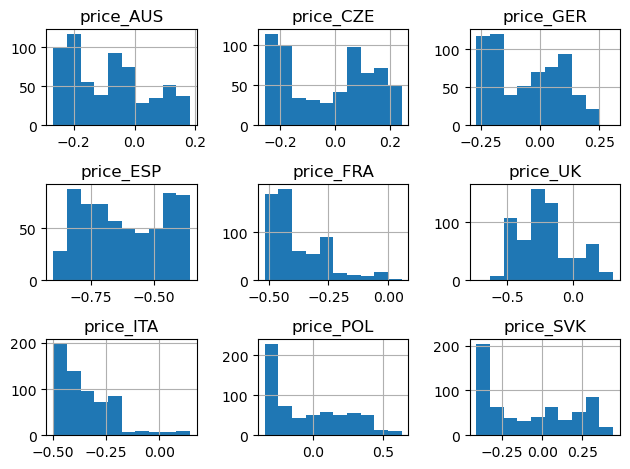

In [20]:
X_train_num_imputed_normscaled.hist()
plt.tight_layout()

## Pipeline creation 
Now that we have explored some preprocessing we implement them into a pipeline to ease the use of our feature preprocessing

In [16]:
# first we define the pipelines that we found above
num_pipeline = make_pipeline(KNNImputer(n_neighbors=5),
                              StandardScaler())
cat_pipeline = make_pipeline(OneHotEncoder())

# second, we merge them into a column selection transformer
preprocessing = ColumnTransformer(transformers=[("num", num_pipeline, make_column_selector(dtype_include=np.number)),
                                                ("cat", cat_pipeline, make_column_selector(dtype_include=object))], 
                                  remainder="passthrough")

X_train_prepared =  preprocessing.fit_transform(X_train)

X_train_prepared_df = pd.DataFrame(X_train_prepared, 
                                   columns = preprocessing.get_feature_names_out())


In [17]:
quick_check(X_train_prepared_df)

,count,mean,std,min,25%,50%,75%,max,NA.counts
num__price_AUS,631.0,5.630291e-17,1.000793,-1.598544,-1.001470,0.061547,0.655727,1.972190,0
num__price_CZE,631.0,3.378175e-17,1.000793,-1.518322,-1.075858,0.335618,0.841191,1.622409,0
num__price_GER,631.0,9.008466e-17,1.000793,-1.515466,-1.044995,0.149659,0.945023,1.884758,0
num__price_ESP,631.0,-4.391627e-16,1.000793,-1.922292,-0.786950,0.212020,0.945799,1.546625,0
num__price_FRA,631.0,1.689087e-17,1.000793,-1.117780,-0.867597,-0.368547,0.822576,2.803469,0
num__price_UK,631.0,0.000000e+00,1.000793,-1.529370,-0.656121,-0.193530,0.435815,2.090002,0
num__price_ITA,631.0,4.504233e-17,1.000793,-1.397787,-0.922261,-0.191708,0.819987,3.258022,0
num__price_POL,631.0,-2.252116e-17,1.000793,-1.248130,-0.987803,-0.178435,1.007862,1.979879,0
num__price_SVK,631.0,2.252116e-17,1.000793,-1.297157,-1.040143,-0.070034,1.013798,1.609073,0
cat__season_autumn,631.0,2.551506e-01,0.436292,0.000000,0.000000,0.000000,1.000000,1.000000,0


# Modeling and Prediction
TODO: Define the model and fit it using training data. Then, use test data to make predictions

## Selecting a Model

In [18]:
# First we define possible regressor pipelines
# lin_reg = make_pipeline(preprocessing, LinearRegression())
# tree_reg = make_pipeline(preprocessing, DecisionTreeRegressor(random_state=42))
kernel_names = ["DotProduct", "RBF", "Matern", "RationalQuadratic"]
kernels = [DotProduct(), RBF(), Matern(length_scale_bounds=(1e-10, 1e10)), RationalQuadratic(length_scale_bounds=(1e-10, 1e10))]
model_pipelines = [Pipeline([("preprocessing", preprocessing), 
                             (f"GPR_{kernel_names[i]}", GaussianProcessRegressor(kernel=kernels[i]))
                             ]) for i in range(len(kernels))]
                            

dirty_rmses = np.zeros((len(kernels), 3), dtype=object)
# Second, quick and dirty goodness of fit
for i, model in enumerate(model_pipelines): 
    model.fit(X_train, y_train)
    y_pred = model.predict(X_train)
    rmse = mean_squared_error(y_pred, y_train)
    model_name = model.steps[-1][0]
    kernel_name = model.steps[-1][1].kernel_
    # print("Model: {} Kernel: {} RMSE: {:10.4e}".format(model_name, kernel_name, rmse))
    dirty_rmses[i, :] = (model_name, kernel_names[i], rmse)
# linear regression (dot product) performs the worst on first look

# for higher accuracy pd.Dataframe display
pd.options.display.float_format = '{:.2e}'.format

pd.DataFrame(dirty_rmses, 
             columns = ["Model", "Kernel", "RMSE"])
# pd.options.display.float_format = None


c:\Users\paesc\anaconda3\envs\py311\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter sigma_0 is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\paesc\anaconda3\envs\py311\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


,Model,Kernel,RMSE
0,GPR_DotProduct,DotProduct,8.00e-01
1,GPR_RBF,RBF,3.17e-19
2,GPR_Matern,Matern,4.97e-19
3,GPR_RationalQuadratic,RationalQuadratic,6.00e-20


## Cross Valiadation

In [19]:
cross_val_list = []
# perform the cross validations
for model in model_pipelines:
    cv_rmses = pd.Series(-cross_val_score(model, X_train, y_train, scoring="neg_root_mean_squared_error", cv=10)).describe()
    cross_val_list.append(cv_rmses)


c:\Users\paesc\anaconda3\envs\py311\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter sigma_0 is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\paesc\anaconda3\envs\py311\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\paesc\anaconda3\envs\py311\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\paesc\anaconda3\envs\py311\Lib\site-packages\sklearn\gaussian_p

In [20]:
pd.DataFrame(cross_val_list, index = kernel_names)
# Matern and RationalQuadratic seem to perform better

,count,mean,std,min,25%,50%,75%,max
DotProduct,1.00e+01,1.05e+00,3.77e-01,7.41e-01,8.47e-01,9.46e-01,1.08e+00,2.05e+00
RBF,1.00e+01,5.41e+00,1.62e+00,3.33e+00,4.09e+00,5.25e+00,6.59e+00,8.17e+00
Matern,1.00e+01,6.91e-01,3.83e-01,4.12e-01,4.81e-01,5.21e-01,6.21e-01,1.50e+00
RationalQuadratic,1.00e+01,7.05e-01,4.83e-01,2.81e-01,4.61e-01,5.05e-01,6.44e-01,1.82e+00


## Fine Tuning of the Pipeline and Model

We choose the RandomizedSearch approach here, as it better suits large seach spaces. Furthermore, we progress our Finetuning with the kernels Matern and RationalQuadratic.

### GPR Matern

In [21]:
gpr_matern = model_pipelines[2]
gpr_rquadratic = model_pipelines[3]

# First we need to get the access string to the hyperparams for the different pipelines
for key in gpr_matern.get_params().keys(): print(key)

memory
steps
verbose
preprocessing
GPR_Matern
preprocessing__n_jobs
preprocessing__remainder
preprocessing__sparse_threshold
preprocessing__transformer_weights
preprocessing__transformers
preprocessing__verbose
preprocessing__verbose_feature_names_out
preprocessing__num
preprocessing__cat
preprocessing__num__memory
preprocessing__num__steps
preprocessing__num__verbose
preprocessing__num__knnimputer
preprocessing__num__standardscaler
preprocessing__num__knnimputer__add_indicator
preprocessing__num__knnimputer__copy
preprocessing__num__knnimputer__keep_empty_features
preprocessing__num__knnimputer__metric
preprocessing__num__knnimputer__missing_values
preprocessing__num__knnimputer__n_neighbors
preprocessing__num__knnimputer__weights
preprocessing__num__standardscaler__copy
preprocessing__num__standardscaler__with_mean
preprocessing__num__standardscaler__with_std
preprocessing__cat__memory
preprocessing__cat__steps
preprocessing__cat__verbose
preprocessing__cat__onehotencoder
preprocessi

In [22]:
# Second, we choose the hyperparameters we want to perform the randomized search on

# Here we could also consider "Halve" search classes fyi

param_distribs = {"preprocessing__num__knnimputer__n_neighbors": randint(2, 20), 
                  "preprocessing__num__knnimputer__weights": ["uniform", "distance"], 
                  "GPR_Matern__kernel__length_scale": uniform(0.1, 3), 
                  "GPR_Matern__kernel__nu": [0.5, 1.5, 2.5, np.inf]} 

rnd_search_matern =  RandomizedSearchCV(gpr_matern, 
                                        param_distributions=param_distribs,
                                        n_iter=10,
                                        cv=3, 
                                        scoring='neg_root_mean_squared_error', 
                                        random_state=42)

rnd_search_matern.fit(X_train, y_train)

c:\Users\paesc\anaconda3\envs\py311\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-10. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\paesc\anaconda3\envs\py311\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-10. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\paesc\anaconda3\envs\py311\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-10. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\paesc\anaconda3\envs\py311\Lib\site-packages\sklearn\gauss

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('num',
                                                                               Pipeline(steps=[('knnimputer',
                                                                                                KNNImputer()),
                                                                                               ('standardscaler',
                                                                                                StandardScaler())]),
                                                                               <sklearn.compose._column_transformer.make_column_selector object at 0x0000013DAFFD1990>),
                                                                              ('cat',
                                                                               Pipeline(steps=[('onehotencoder',
                                                                                                OneHotEncode...
                   param_distributions={'GPR_Matern__kernel__length_scale': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000013DAFC2B690>,
                                        'GPR_Matern__kernel__nu': [0.5, 1.5,
                                                                   2.5, inf],
                                        'preprocessing__num__knnimputer__n_neighbors': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000013DAFACA7D0>,
                                        'preprocessing__num__knnimputer__weights': ['uniform',
                                                                                    'distance']},
                   random_state=42, scoring='neg_root_mean_squared_error')

In [23]:
# find the best estimator
rnd_search_matern.best_estimator_
rnd_search_matern.best_params_

{'GPR_Matern__kernel__length_scale': 2.439073000818308,
 'GPR_Matern__kernel__nu': 0.5,
 'preprocessing__num__knnimputer__n_neighbors': 8,
 'preprocessing__num__knnimputer__weights': 'distance'}

In [24]:
# extract the matern model with the best params
final_gpr_matern = rnd_search_matern.best_estimator_## Fine Tuning of the Pipeline and Model
print(rnd_search_matern.best_score_)

-0.8237226828719563


In [25]:
###  Rational Quadratic

In [26]:
# First we need to get the access string to the hyperparams for the different pipelines
for key in gpr_rquadratic.get_params().keys(): print(key)
# Second, we choose the hyperparameters we want to perform the randomized search on

memory
steps
verbose
preprocessing
GPR_RationalQuadratic
preprocessing__n_jobs
preprocessing__remainder
preprocessing__sparse_threshold
preprocessing__transformer_weights
preprocessing__transformers
preprocessing__verbose
preprocessing__verbose_feature_names_out
preprocessing__num
preprocessing__cat
preprocessing__num__memory
preprocessing__num__steps
preprocessing__num__verbose
preprocessing__num__knnimputer
preprocessing__num__standardscaler
preprocessing__num__knnimputer__add_indicator
preprocessing__num__knnimputer__copy
preprocessing__num__knnimputer__keep_empty_features
preprocessing__num__knnimputer__metric
preprocessing__num__knnimputer__missing_values
preprocessing__num__knnimputer__n_neighbors
preprocessing__num__knnimputer__weights
preprocessing__num__standardscaler__copy
preprocessing__num__standardscaler__with_mean
preprocessing__num__standardscaler__with_std
preprocessing__cat__memory
preprocessing__cat__steps
preprocessing__cat__verbose
preprocessing__cat__onehotencoder


In [27]:
# Here we could also consider "Halve" search classes fyi

param_distribs = {"preprocessing__num__knnimputer__n_neighbors": randint(2, 20), 
                  "preprocessing__num__knnimputer__weights": ["uniform", "distance"], 
                  "GPR_RationalQuadratic__kernel__length_scale": uniform(0.1, 3), 
                  "GPR_RationalQuadratic__kernel__alpha": uniform(0.1, 3)} 

rnd_search_rquadratic =  RandomizedSearchCV(gpr_rquadratic, 
                                            param_distributions=param_distribs,
                                            n_iter=10,
                                            cv=3, 
                                            scoring='neg_root_mean_squared_error', 
                                            random_state=42)

rnd_search_rquadratic.fit(X_train, y_train)
# find the best estimator
print(rnd_search_rquadratic.best_params_)
print(rnd_search_rquadratic.best_score_)
# extract the matern model with the best params
final_gpr_rquadratic = rnd_search_rquadratic.best_estimator_

{'GPR_RationalQuadratic__kernel__alpha': 0.26923473708130075, 'GPR_RationalQuadratic__kernel__length_scale': 2.265996316800474, 'preprocessing__num__knnimputer__n_neighbors': 7, 'preprocessing__num__knnimputer__weights': 'distance'}
-1.0701185259866308


# Analyzing the Best Models and Their Errors

In [28]:
# feature_importances_matern = final_gpr_matern["GPR_Matern"].feature_importances_
# final_gpr_matern.get_param


In [29]:
"""
This defines the model, fits training data and then does the prediction
with the test data 

Parameters
----------
X_train: matrix of floats, training input with 10 features
y_train: array of floats, training output
X_test: matrix of floats: dim = (100, ?), test input with 10 features

Compute
----------
y_test: array of floats: dim = (100,), predictions on test set
"""

y_pred=final_gpr_matern.predict(X_test)
#TODO: Define the model and fit it using training data. Then, use test data to make predictions

assert y_pred.shape == (100,), "Invalid data shape"

# Saving Results
You don't have to change this

In [30]:
dt = pd.DataFrame(y_pred) 
dt.columns = ['price_CHF']
dt.to_csv('single_results.csv', index=False)
print("\nResults file successfully generated!")


Results file successfully generated!
